<a href="https://colab.research.google.com/github/LatiefDataVisionary/text-mining-and-natural-language-processing-college-task/blob/main/ygDipakai_decision_tree_model_lagi_dikerjain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Import Library yang Digunakan**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns # Untuk visualisasi yang lebih menarik
import graphviz # Untuk visualisasi graphviz
import nltk # Untuk pra-pemrosesan teks lebih lanjut
from nltk.stem import WordNetLemmatizer # Untuk lemmatization
from nltk.corpus import stopwords as nltk_stopwords # Untuk custom stop words
from imblearn.over_sampling import SMOTE # Untuk penanganan imbalanced dataset
from sklearn.feature_selection import SelectKBest, chi2 # Untuk pemilihan fitur
from collections import Counter # Untuk menghitung distribusi kelas
import re # Untuk pra-pemrosesan teks (regex)

# Download resource NLTK yang mungkin dibutuhkan
# Catch the LookupError directly when nltk.data.find fails
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("NLTK resource 'wordnet' not found. Downloading...")
    nltk.download('wordnet')
except Exception as e:
    print(f"An unexpected error occurred while checking/downloading 'wordnet': {e}")

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    print("NLTK resource 'omw-1.4' not found. Downloading...")
    nltk.download('omw-1.4') # WordNet multilingual resource
except Exception as e:
    print(f"An unexpected error occurred while checking/downloading 'omw-1.4': {e}")

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("NLTK resource 'stopwords' not found. Downloading...")
    nltk.download('stopwords')
except Exception as e:
    print(f"An unexpected error occurred while checking/downloading 'stopwords': {e}")

# Tambahkan download punkt dan punkt_tab jika diperlukan untuk word_tokenize
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("NLTK resource 'punkt' not found. Downloading...")
    nltk.download('punkt')
except Exception as e:
    print(f"An unexpected error occurred while checking/downloading 'punkt': {e}")

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("NLTK resource 'punkt_tab' not found. Downloading...")
    nltk.download('punkt_tab')
except Exception as e:
    print(f"An unexpected error occurred while checking/downloading 'punkt_tab': {e}")


# Pengaturan umum untuk plot agar lebih menarik
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis") # Atau palet lain seperti 'pastel', 'muted'

NLTK resource 'wordnet' not found. Downloading...
NLTK resource 'omw-1.4' not found. Downloading...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
path = 'https://raw.githubusercontent.com/LatiefDataVisionary/text-mining-and-natural-language-processing-college-task/refs/heads/main/datasets/ramadan_labeled_sentiment.csv'
df = pd.read_csv(path)

print(f"Dataset berhasil di-load dari: {path}")
print(f"Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}")

Dataset berhasil di-load dari: https://raw.githubusercontent.com/LatiefDataVisionary/text-mining-and-natural-language-processing-college-task/refs/heads/main/datasets/ramadan_labeled_sentiment.csv
Jumlah baris: 836, Jumlah kolom: 8


## **- Tahap Pra-Pemrosesan Data (Data Preprocessing)**


### **c. Pemrosesan Kolom Teks Fitur (Lemmatization dan Stop Word Removal):**


Kolom `tweet_clean` saat ini tampaknya berisi string yang merepresentasikan list. Ini perlu diubah menjadi string tunggal dari kata-kata yang digabungkan.


In [ ]:
# Pastikan NLTK resources sudah ada atau diunduh
# (Kode ini sebaiknya ada di awal notebook, saya sertakan di sini untuk kelengkapan)
# import nltk

# Explicitly download required NLTK resources
# nltk.download('wordnet', quiet=True)
# nltk.download('omw-1.4', quiet=True)
# nltk.download('stopwords', quiet=True)
# nltk.download('punkt', quiet=True)
# nltk.download('punkt_tab', quiet=True)


# Import library yang relevan untuk tahap ini
# import re
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer # Menggunakan PorterStemmer untuk stemming
# from nltk.corpus import stopwords as nltk_stopwords
# from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer

# pandas dan WordNetLemmatizer sudah diimport sebelumnya

In [ ]:
# --- MULAI KODE UNTUK LANGKAH 1: PREPROCESSING TEKS ---

# Fungsi untuk menggabungkan list kata menjadi string (masih relevan dari kode awal Anda)
def join_text_list(text_list_str):
    if isinstance(text_list_str, str):
        try:
            actual_list = eval(text_list_str)
            if isinstance(actual_list, list):
                return ' '.join(actual_list)
            else:
                return str(text_list_str)
        except Exception:
            return str(text_list_str)
    elif isinstance(text_list_str, list):
        return ' '.join(text_list_str)
    return str(text_list_str)

# Mengaplikasikan join_text_list ke kolom 'tweet_clean' untuk mendapatkan teks mentah
# yang akan diproses. Kolom ini digunakan agar proses evaluasi lebih konsisten
# dengan bagaimana 'text_processed_raw' dibuat di kode asli.
df['text_processed_raw'] = df['tweet_clean'].apply(join_text_list)


# Inisialisasi Lemmatizer dan Stop Words
# Menggunakan WordNetLemmatizer untuk lemmatization
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk_stopwords.words('english'))
# Anda bisa tambahkan custom stop words di sini jika perlu, contoh:
# custom_stopwords = {'ramadan', 'mubarak', 'also', 'like', 'would'}
# all_stopwords = english_stopwords.union(custom_stopwords)
# Untuk saat ini, kita gunakan default NLTK English stopwords

def preprocess_text_step1(text):
    if not isinstance(text, str): # Pastikan input adalah string
        return ""

    # 1. Case Folding: Mengubah semua teks menjadi huruf kecil
    text = text.lower()

    # Tambahan: Menghilangkan URL, mention, hashtag (opsional, tapi baik untuk tweet)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Menghilangkan URL
    text = re.sub(r'\@\w+|\#','', text) # Menghilangkan mention dan hashtag symbols

    # Tambahan: Menghilangkan karakter non-alfanumerik kecuali spasi (menyisakan kata dan angka)
    # Jika ingin hanya alphabet: text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Membiarkan angka, atau bisa juga dihilangkan jika diinginkan


    # 2. Tokenizing: Memecah teks menjadi token/kata
    # Menggunakan word_tokenize dari NLTK untuk tokenisasi yang lebih baik
    tokens = word_tokenize(text, language='english') # Explicitly specify language

    # 3. Stopword Removal dan 4. Lemmatization
    processed_tokens = []
    for token in tokens:
        # Hanya proses token yang berupa alphabet dan bukan stopword
        if token.isalpha() and token not in english_stopwords:
            # Lakukan lemmatization
            # 'v' untuk verb, 'n' untuk noun, dll. Defaultnya 'n'. Mungkin perlu eksplorasi POS tagging
            lemmatized_token = lemmatizer.lemmatize(token)
            processed_tokens.append(lemmatized_token)

    return ' '.join(processed_tokens)

print("\nMemulai Tahap 1: Pra-pemrosesan Teks (Case Folding, Tokenizing, Stopword Removal, Lemmatization)...")
# Kolom 'text_processed' akan berisi hasil dari pra-pemrosesan lengkap tahap 1 ini
df['text_processed'] = df['text_processed_raw'].apply(preprocess_text_step1)

print("\nContoh hasil 'text_processed' setelah pra-pemrosesan Tahap 1:")
display(df[['tweet_clean', 'text_processed_raw', 'text_processed', 'sentiment']].head())

print("\nMemeriksa missing values di kolom 'text_processed' setelah pra-pemrosesan:")
print(f"Jumlah missing values: {df['text_processed'].isnull().sum()}")
# Jika ada missing values (misal dari tweet yang jadi string kosong setelah preprocessing),
# kita bisa isi dengan string kosong agar TfidfVectorizer tidak error
df['text_processed'].fillna('', inplace=True)
print(f"Jumlah missing values setelah fillna: {df['text_processed'].isnull().sum()}")

# --- AKHIR KODE UNTUK LANGKAH 1 ---


Memulai Tahap 1: Pra-pemrosesan Teks (Case Folding, Tokenizing, Stopword Removal, Lemmatization)...

Contoh hasil 'text_processed' setelah pra-pemrosesan Tahap 1:


,tweet_clean,text_processed_raw,text_processed,sentiment
0,"['abraj', 'al', 'bait', 'clock', 'tower', 'bea...",abraj al bait clock tower beams indicating com...,abraj al bait clock tower beam indicating comm...,negative
1,"['accounts', 'recognised', 'ramadan', 'none', ...",accounts recognised ramadan none recognised be...,account recognised ramadan none recognised beg...,negative
2,"['admin', 'post', 'peaceful', 'ramadan', 'cele...",admin post peaceful ramadan celebrations east ...,admin post peaceful ramadan celebration east l...,positive
3,"['admin', 'post', 'ramadan', 'norway']",admin post ramadan norway,admin post ramadan norway,negative
4,"['admin', 'post', 'ramadan', 'usual', 'peacefu...",admin post ramadan usual peaceful start englan...,admin post ramadan usual peaceful start englan...,positive



Memeriksa missing values di kolom 'text_processed' setelah pra-pemrosesan:
Jumlah missing values: 0
Jumlah missing values setelah fillna: 0


<ipython-input-33-2353637989>:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text_processed'].fillna('', inplace=True)


## **- Tahap Ekstraksi Fitur (TF-IDF Vectorization)**

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Kita bisa coba tuning parameter TF-IDF ini nantinya jika akurasi masih kurang
tfidf = TfidfVectorizer(
    max_features=1500,    # Coba tingkatkan jumlah fitur
    ngram_range=(1, 2),   # Tetap pertimbangkan unigram dan bigram
    stop_words='english', # Stop words sudah ditangani sebagian di pra-pemrosesan, tapi bisa tetap di sini
    min_df=3,             # Abaikan term yang muncul di kurang dari 3 dokumen
    max_df=0.9            # Abaikan term yang muncul di lebih dari 90% dokumen (terlalu umum)
)

X = tfidf.fit_transform(df['text_processed'])

# Map 'positive' to 1 and 'negative' to 0
sentiment_mapping = {'positive': 1, 'negative': 0}
y = df['sentiment'].map(sentiment_mapping).astype(int) # Map and then convert to integer

# from imblearn.over_sampling import SMOTE

# smote=SMOTE(sampling_strategy='auto')
# X,y=smote.fit_resample(X,y)

print(f"Shape dari matriks fitur X (setelah TF-IDF): {X.shape}")
print(f"Shape dari vektor target y: {y.shape}")

# Menampilkan jumlah fitur aktual yang digunakan
# Check if tfidf has feature_names_in_ or feature_names_out_
if hasattr(tfidf, 'get_feature_names_out'):
    feature_names = tfidf.get_feature_names_out()
elif hasattr(tfidf, 'feature_names_in_'):
     feature_names = tfidf.feature_names_in_
else:
    feature_names = [] # Fallback if neither attribute exists

print(f"Jumlah fitur aktual yang digunakan oleh TF-IDF: {len(feature_names)}")
if len(feature_names) > 0: # Check if the list/array is not empty by checking its length
    print("\nContoh beberapa fitur teratas:")
    print(list(feature_names)[:20])
else:
    print("\nTidak dapat menampilkan contoh fitur.")

Shape dari matriks fitur X (setelah TF-IDF): (836, 941)
Shape dari vektor target y: (836,)
Jumlah fitur aktual yang digunakan oleh TF-IDF: 941

Contoh beberapa fitur teratas:
['able', 'abu', 'accept', 'accepted', 'according', 'account', 'act', 'act worship', 'action', 'activist', 'activity', 'additionally', 'admin', 'admin post', 'ago', 'ah', 'ahead', 'ahmed', 'aid', 'al']


## **3. Pemrosesan Pembagian (Split Data) Data Training dan Data Testing**


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,  # 20% data digunakan untuk testing
    random_state=42,  # Untuk reproduktifitas hasil
)

print("Ukuran Data Setelah Pembagian:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\nDistribusi kelas pada data training (proporsi):")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

print("\nDistribusi kelas pada data testing (proporsi):")
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

Ukuran Data Setelah Pembagian:
X_train shape: (668, 941), y_train shape: (668,)
X_test shape: (168, 941), y_test shape: (168,)

Distribusi kelas pada data training (proporsi):
sentiment
1    0.52994
0    0.47006
Name: proportion, dtype: float64
sentiment
1    354
0    314
Name: count, dtype: int64

Distribusi kelas pada data testing (proporsi):
sentiment
1    0.547619
0    0.452381
Name: proportion, dtype: float64
sentiment
1    92
0    76
Name: count, dtype: int64


## **SMOTE**

In [ ]:
# # --- MULAI KODE UNTUK LANGKAH 5: PENANGANAN KETIDAKSEIMBANGAN DATASET (SMOTE) ---

# # Import library yang dibutuhkan
# from imblearn.over_sampling import SMOTE
# from sklearn.tree import DecisionTreeClassifier # Jika best_dt_model belum ada
# from sklearn.metrics import accuracy_score
# import pandas as pd # Untuk value_counts dan DataFrame
# from collections import Counter # Untuk menghitung distribusi kelas

# # Asumsi X_train, y_train, X_test, y_test sudah ada dari tahap split data
# # Dan tfidf sudah di-fit pada X_train (jika X_train adalah sparse matrix dari TF-IDF)

# # 0. Persiapan Data untuk Tabel Laporan
# smote_results = {
#     "SMOTE": ["Oversampling (jumlah kelas minoritas)", "Undersampling (jumlah kelas mayoritas)", "Hasil akurasi"],
#     "Sebelum": [None, None, None],
#     "Sesudah": [None, None, None]
# }

# # 1. Hitung Akurasi SEBELUM SMOTE
# print("--- EVALUASI MODEL SEBELUM SMOTE ---")
# # Gunakan best_dt_model jika sudah ada dari GridSearchCV, atau inisialisasi model baru
# try:
#     model_before_smote = best_dt_model
#     print("Menggunakan best_dt_model dari GridSearchCV untuk evaluasi sebelum SMOTE.")
# except NameError:
#     print("best_dt_model tidak ditemukan, menggunakan DecisionTreeClassifier default.")
#     model_before_smote = DecisionTreeClassifier(random_state=42)

# # Melatih model pada data training asli
# model_before_smote.fit(X_train, y_train)
# y_pred_before_smote = model_before_smote.predict(X_test)
# accuracy_before_smote = accuracy_score(y_test, y_pred_before_smote)
# print(f"Akurasi pada data testing SEBELUM SMOTE: {accuracy_before_smote:.4f}")
# smote_results["Sebelum"][2] = f"{accuracy_before_smote:.4f}"

# # Distribusi kelas SEBELUM SMOTE
# counts_before_smote = Counter(y_train)
# print("\nDistribusi kelas pada data training SEBELUM SMOTE:")
# for cls, count in counts_before_smote.items():
#     print(f"Kelas {cls}: {count}")

# # Tentukan kelas minoritas dan mayoritas untuk pelaporan
# if len(counts_before_smote) == 2: # Biner
#     class_labels = list(counts_before_smote.keys())
#     if counts_before_smote[class_labels[0]] < counts_before_smote[class_labels[1]]:
#         minority_class_label_before = class_labels[0]
#         majority_class_label_before = class_labels[1]
#     else:
#         minority_class_label_before = class_labels[1]
#         majority_class_label_before = class_labels[0]

#     smote_results["Sebelum"][0] = counts_before_smote[minority_class_label_before] # Oversampling (minority count)
#     smote_results["Sebelum"][1] = counts_before_smote[majority_class_label_before] # Undersampling (majority count)
# elif len(counts_before_smote) > 0 : # Jika datasetnya imbang atau hanya ada satu kelas (jarang terjadi di sini)
#     # Untuk dataset yang sudah imbang atau hanya satu kelas, SMOTE mungkin tidak mengubah banyak
#     # Kita ambil saja kelas pertama sebagai "minoritas" dan "mayoritas" untuk pelaporan
#     first_class_label = list(counts_before_smote.keys())[0]
#     minority_class_label_before = first_class_label
#     majority_class_label_before = first_class_label
#     smote_results["Sebelum"][0] = counts_before_smote[minority_class_label_before]
#     smote_results["Sebelum"][1] = counts_before_smote[majority_class_label_before]
# else: # Dataset kosong
#     minority_class_label_before = None
#     majority_class_label_before = None
#     smote_results["Sebelum"][0] = 0
#     smote_results["Sebelum"][1] = 0


# # 2. Penerapan SMOTE
# print("\n--- MENERAPKAN SMOTE PADA DATA TRAINING ---")

# # Parameter k_neighbors untuk SMOTE
# # SMOTE memerlukan jumlah sampel di kelas minoritas minimal k_neighbors + 1
# k_neighbors_smote = 5
# if minority_class_label_before is not None and counts_before_smote[minority_class_label_before] <= k_neighbors_smote:
#     # Jika kelas minoritas terlalu kecil, kurangi k_neighbors
#     # (Minimal k_neighbors adalah 1 jika kelas minoritas > 1)
#     k_neighbors_smote = max(1, counts_before_smote[minority_class_label_before] - 1)
#     if k_neighbors_smote == 0 and counts_before_smote[minority_class_label_before] == 1:
#          print(f"Peringatan: Kelas minoritas ({minority_class_label_before}) hanya memiliki 1 sampel. SMOTE tidak dapat diterapkan.")
#          # Tetapkan X_train_smote dan y_train_smote sama dengan X_train dan y_train
#          X_train_smote, y_train_smote = X_train, y_train
#          smote_applied_successfully = False
#     elif counts_before_smote[minority_class_label_before] == 0 :
#         print(f"Peringatan: Kelas minoritas ({minority_class_label_before}) tidak memiliki sampel. SMOTE tidak dapat diterapkan.")
#         X_train_smote, y_train_smote = X_train, y_train
#         smote_applied_successfully = False
#     else:
#         print(f"Peringatan: Jumlah sampel kelas minoritas ({counts_before_smote[minority_class_label_before]}) <= k_neighbors awal (5). "
#               f"Menggunakan k_neighbors={k_neighbors_smote} untuk SMOTE.")
#         smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors_smote)
#         X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#         smote_applied_successfully = True

# elif minority_class_label_before is None or counts_before_smote[minority_class_label_before] == 0 : # Kasus dataset awal kosong atau tidak ada minoritas
#      print(f"Peringatan: Tidak ada kelas minoritas yang teridentifikasi atau kelas minoritas kosong. SMOTE tidak diterapkan.")
#      X_train_smote, y_train_smote = X_train, y_train
#      smote_applied_successfully = False
# else:
#     smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors_smote)
#     # Terapkan SMOTE hanya pada data training
#     X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#     smote_applied_successfully = True
#     print(f"SMOTE berhasil diterapkan dengan k_neighbors={k_neighbors_smote}.")


# # Distribusi kelas SETELAH SMOTE
# counts_after_smote = Counter(y_train_smote)
# print("\nDistribusi kelas pada data training SETELAH SMOTE:")
# for cls, count in counts_after_smote.items():
#     print(f"Kelas {cls}: {count}")

# # Mengisi hasil "Sesudah" untuk tabel laporan
# # Untuk SMOTE (auto), jumlah sampel di kelas minoritas akan sama dengan kelas mayoritas asli
# if smote_applied_successfully and minority_class_label_before is not None :
#     smote_results["Sesudah"][0] = counts_after_smote[minority_class_label_before] # Oversampling (minority count - now balanced)
#     # Jika 'auto', jumlah kelas mayoritas tidak berubah jika dia adalah mayoritas awal.
#     # Atau, jika 'minority', dia akan sama dengan mayoritas baru (yaitu sama dg minoritas yg di-oversample).
#     # Dengan 'auto', semua kelas menjadi sama dengan jumlah sampel kelas mayoritas awal.
#     smote_results["Sesudah"][1] = counts_after_smote[majority_class_label_before] # Undersampling (majority count - now balanced)
# else: # Jika SMOTE tidak berhasil atau tidak ada minoritas
#     if minority_class_label_before is not None and majority_class_label_before is not None :
#         smote_results["Sesudah"][0] = counts_before_smote[minority_class_label_before]
#         smote_results["Sesudah"][1] = counts_before_smote[majority_class_label_before]
#     else:
#         smote_results["Sesudah"][0] = 0
#         smote_results["Sesudah"][1] = 0


# print(f"\nShape data training asli: X_train-{X_train.shape}, y_train-{y_train.shape}")
# print(f"Shape data training setelah SMOTE: X_train_smote-{X_train_smote.shape}, y_train_smote-{y_train_smote.shape}")


# # 3. Hitung Akurasi SETELAH SMOTE
# print("\n--- EVALUASI MODEL SETELAH SMOTE ---")
# # Gunakan parameter terbaik yang sama (jika ada) atau model default yang sama
# try:
#     # Buat instance baru dari model dengan parameter terbaik untuk dilatih pada data SMOTE
#     # atau gunakan model yang sama jika state-nya direset setelah .fit()
#     # Untuk DecisionTreeClassifier, .fit() akan melatih ulang
#     model_after_smote = best_dt_model
#     print("Menggunakan best_dt_model dari GridSearchCV untuk evaluasi setelah SMOTE.")
# except NameError:
#     print("best_dt_model tidak ditemukan, menggunakan DecisionTreeClassifier default.")
#     model_after_smote = DecisionTreeClassifier(random_state=42)


# # Melatih model pada data training yang sudah di-SMOTE
# model_after_smote.fit(X_train_smote, y_train_smote)
# y_pred_after_smote = model_after_smote.predict(X_test)
# accuracy_after_smote = accuracy_score(y_test, y_pred_after_smote)
# print(f"Akurasi pada data testing SETELAH SMOTE: {accuracy_after_smote:.4f}")
# smote_results["Sesudah"][2] = f"{accuracy_after_smote:.4f}"


# # 4. Tampilkan Tabel Perbandingan Hasil
# print("\n\n--- PERBANDINGAN HASIL SMOTE ---")
# df_smote_results = pd.DataFrame(smote_results)
# # display(df_smote_results) # Untuk tampilan tabel yang lebih baik di notebook

# # Untuk output teks yang diminta (agar bisa langsung dicopy ke laporan)
# # Menentukan label kelas 0 dan 1 (asumsi sudah di-map dari 'negative' dan 'positive')
# # Dari kode sebelumnya y_train sudah numerik.
# # Jika kita tahu mana yang minoritas (misal kelas 0) dan mayoritas (kelas 1) sebelum SMOTE
# # (Perlu di-adjust jika labelnya berbeda atau multi-kelas)

# label_kelas_0_before = counts_before_smote.get(0, 0)
# label_kelas_1_before = counts_before_smote.get(1, 0)
# label_kelas_0_after = counts_after_smote.get(0, 0)
# label_kelas_1_after = counts_after_smote.get(1, 0)

# # Mengisi tabel sesuai format yang diminta:
# # "Oversampling (jumlah dataset)" -> kita interpretasikan sebagai jumlah dataset kelas MINORITAS
# # "Undersampling (jumlah dataset)" -> kita interpretasikan sebagai jumlah dataset kelas MAYORITAS

# # Menentukan mana yang minoritas dan mayoritas sebelum SMOTE
# if label_kelas_0_before < label_kelas_1_before:
#     val_oversampling_sebelum = label_kelas_0_before
#     val_undersampling_sebelum = label_kelas_1_before
# else:
#     val_oversampling_sebelum = label_kelas_1_before
#     val_undersampling_sebelum = label_kelas_0_before

# # Setelah SMOTE (auto), kedua kelas akan memiliki jumlah yang sama dengan mayoritas awal
# # Jadi, "Oversampling (jumlah dataset)" sesudah = jumlah baru kelas minoritas (yang jadi = mayoritas awal)
# # Dan "Undersampling (jumlah dataset)" sesudah = jumlah kelas mayoritas (yang jadi = mayoritas awal)
# if smote_applied_successfully:
#     # Dengan sampling_strategy='auto', kelas minoritas akan dioversample hingga sama dengan mayoritas.
#     # Jika awalnya kelas 0 minoritas:
#     #   val_oversampling_sesudah akan jadi jumlah kelas 0 setelah SMOTE (sama dg mayoritas)
#     #   val_undersampling_sesudah akan jadi jumlah kelas 1 setelah SMOTE (sama dg mayoritas)
#     # Kita bisa ambil saja salah satu karena jumlahnya sama (misal counts_after_smote[majority_class_label_before])
#     val_oversampling_sesudah = counts_after_smote.get(minority_class_label_before, 0)
#     val_undersampling_sesudah = counts_after_smote.get(majority_class_label_before, 0)
#     if not (val_oversampling_sesudah == val_undersampling_sesudah): #Jika strategi smote tidak auto atau ada kesalahan logika
#         #ambil salah satu sebagai nilai balancing, karena harusnya keduanya jadi sama.
#         #disini mengambil kelas dengan nilai maksimum setelah smote sebagai target balancing
#         val_oversampling_sesudah = max(counts_after_smote.values()) if counts_after_smote else 0
#         val_undersampling_sesudah = val_oversampling_sesudah


# else: # Jika SMOTE tidak diterapkan
#     val_oversampling_sesudah = val_oversampling_sebelum
#     val_undersampling_sesudah = val_undersampling_sebelum


# print("\nTuliskan perbandingan hasilnya pada tabel di bawah ini:")
# print(f"{'':<15} | {'Sebelum':<35} | {'Sesudah':<35}")
# print(f"{'-'*15} | {'-'*35} | {'-'*35}")
# print(f"{'SMOTE':<15} | {'':<35} | {'':<35}")
# print(f"{'  Oversampling':<13} | {str(val_oversampling_sebelum) + ' (jumlah kelas minoritas awal)':<35} | {str(val_oversampling_sesudah) + ' (jumlah kelas minoritas setelah SMOTE)':<35}")
# print(f"{'  Undersampling':<13} | {str(val_undersampling_sebelum) + ' (jumlah kelas mayoritas awal)':<35} | {str(val_undersampling_sesudah) + ' (jumlah kelas mayoritas setelah SMOTE*)':<35}")
# print(f"{'-'*15} | {'-'*35} | {'-'*35}")
# print(f"{'Hasil akurasi':<15} | {accuracy_before_smote:<35.4f} | {accuracy_after_smote:<35.4f}")
# print(f"\n* Catatan: SMOTE dengan sampling_strategy='auto' akan meningkatkan jumlah sampel kelas minoritas agar seimbang dengan kelas mayoritas. Kelas mayoritas tidak di-undersample oleh SMOTE itu sendiri.")

# # --- AKHIR KODE UNTUK LANGKAH 5 ---

In [ ]:
# # --- MULAI KODE UNTUK LANGKAH 5: PENANGANAN KETIDAKSEIMBANGAN DATASET (SMOTE) ---

# Import library yang dibutuhkan
# from imblearn.over_sampling import SMOTE
# # from imblearn.under_sampling import RandomUnderSampler # Contoh jika ingin mencoba undersampling
# from sklearn.tree import DecisionTreeClassifier # Jika best_dt_model belum ada
# from sklearn.metrics import accuracy_score, classification_report
# import pandas as pd # Untuk value_counts dan DataFrame
# from collections import Counter # Untuk menghitung distribusi kelas

# Asumsi X_train, y_train, X_test, y_test sudah ada dari tahap split data
# Dan tfidf sudah di-fit (jika X_train adalah sparse matrix dari TF-IDF)

# --- Tuliskan/screenshot SMOTE yang digunakan: ---
# Jawab: Menggunakan SMOTE (Synthetic Minority Over-sampling Technique)
# Untuk menyeimbangkan dataset training dengan melakukan oversampling pada kelas minoritas.
# Di sini kita akan fokus pada SMOTE sebagai teknik oversampling.
# Untuk undersampling, bisa menggunakan RandomUnderSampler atau teknik lain sebagai alternatif,
# namun SMOTE sendiri adalah oversampling.

# 0. Persiapan Data untuk Tabel Laporan
# Format baru tabel laporan:
# |                  | Sebelum        | Sesudah         |
# | SMOTE            | Oversampling   | Oversampling    |
# |                  | Perbandingan.. | Perbandingan..  |
# | Hasil Akurasi    | Akurasi        | Akurasi         |

print("--- EVALUASI MODEL SEBELUM PENYEIMBANGAN DATASET (SMOTE SEBAGAI OVERSAMPLING) ---")
# Gunakan best_dt_model jika sudah ada, atau inisialisasi model baru
try:
    model_before_balancing = best_dt_model
    print("Menggunakan best_dt_model dari GridSearchCV untuk evaluasi sebelum SMOTE.")
except NameError:
    print("best_dt_model tidak ditemukan, menggunakan DecisionTreeClassifier default.")
    model_before_balancing = DecisionTreeClassifier(random_state=42)

# Melatih model pada data training asli
model_before_balancing.fit(X_train, y_train)
y_pred_before_balancing = model_before_balancing.predict(X_test)
accuracy_before_balancing = accuracy_score(y_test, y_pred_before_balancing)
print(f"Akurasi pada data testing SEBELUM SMOTE: {accuracy_before_balancing:.4f}")
print("\nLaporan Klasifikasi SEBELUM SMOTE:")
print(classification_report(y_test, y_pred_before_balancing, target_names=['Negative (0)', 'Positive (1)']))


# Distribusi kelas SEBELUM SMOTE
counts_before_balancing = Counter(y_train)
print("\nDistribusi kelas pada data training SEBELUM SMOTE:")
perbandingan_dataset_sebelum = ""
for cls, count in sorted(counts_before_balancing.items()): # sort agar urutan kelas konsisten
    print(f"Kelas {int(cls)}: {count}")
    perbandingan_dataset_sebelum += f"Kelas {int(cls)}: {count}; "
perbandingan_dataset_sebelum = perbandingan_dataset_sebelum.strip().rstrip(';')

# Tentukan kelas minoritas (untuk info SMOTE)
if len(counts_before_balancing) == 2:
    class_labels_before = list(counts_before_balancing.keys())
    if counts_before_balancing[class_labels_before[0]] < counts_before_balancing[class_labels_before[1]]:
        minority_class_label_before = class_labels_before[0]
    else:
        minority_class_label_before = class_labels_before[1]
elif len(counts_before_balancing) == 1: # Jika hanya ada satu kelas
    minority_class_label_before = list(counts_before_balancing.keys())[0]
else: # Dataset kosong atau lebih dari 2 kelas (SMOTE imblearn defaultnya menangani biner dan multikelas minoritas)
    minority_class_label_before = None # Perlu logika lebih lanjut untuk multikelas yang kompleks


# 1. Penerapan SMOTE (Oversampling)
print("\n--- MENERAPKAN SMOTE (OVERSAMPLING) PADA DATA TRAINING ---")

k_neighbors_smote = 5
X_train_balanced, y_train_balanced = X_train, y_train # Default jika SMOTE tidak bisa diterapkan
smote_applied_successfully = False

if minority_class_label_before is not None and counts_before_balancing[minority_class_label_before] > 0 :
    if counts_before_balancing[minority_class_label_before] <= k_neighbors_smote:
        k_neighbors_smote_actual = max(1, counts_before_balancing[minority_class_label_before] - 1)
        if k_neighbors_smote_actual == 0: # Terjadi jika kelas minoritas hanya punya 1 sampel
            print(f"Peringatan: Kelas minoritas ({int(minority_class_label_before)}) hanya memiliki 1 sampel. SMOTE tidak dapat diterapkan.")
        else:
            print(f"Peringatan: Jumlah sampel kelas minoritas ({counts_before_balancing[minority_class_label_before]}) <= k_neighbors awal (5). "
                  f"Menggunakan k_neighbors={k_neighbors_smote_actual} untuk SMOTE.")
            smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors_smote_actual)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
            smote_applied_successfully = True
    else:
        k_neighbors_smote_actual = k_neighbors_smote
        smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors_smote_actual)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        smote_applied_successfully = True
        print(f"SMOTE berhasil diterapkan dengan k_neighbors={k_neighbors_smote_actual}.")
else:
    print("Peringatan: Tidak ada kelas minoritas yang valid untuk SMOTE atau dataset kosong. SMOTE tidak diterapkan.")
    k_neighbors_smote_actual = 0 # Set to 0 if SMOTE was not applied

# Distribusi kelas SETELAH SMOTE
counts_after_balancing = Counter(y_train_balanced)
print("\nDistribusi kelas pada data training SETELAH SMOTE:")
perbandingan_dataset_sesudah = ""
for cls, count in sorted(counts_after_balancing.items()):
    print(f"Kelas {int(cls)}: {count}")
    perbandingan_dataset_sesudah += f"Kelas {int(cls)}: {count}; "
perbandingan_dataset_sesudah = perbandingan_dataset_sesudah.strip().rstrip(';')

print(f"\nShape data training asli: X_train-{X_train.shape}, y_train-{y_train.shape}")
print(f"Shape data training setelah SMOTE: X_train_balanced-{X_train_balanced.shape}, y_train_balanced-{y_train_balanced.shape}")

# 2. Hitung Akurasi SETELAH SMOTE
print("\n--- EVALUASI MODEL SETELAH SMOTE (OVERSAMPLING) ---")
try:
    model_after_balancing = best_dt_model
    print("Menggunakan best_dt_model dari GridSearchCV untuk evaluasi setelah SMOTE.")
except NameError:
    print("best_dt_model tidak ditemukan, menggunakan DecisionTreeClassifier default.")
    model_after_balancing = DecisionTreeClassifier(random_state=42)

# Melatih model pada data training yang sudah diseimbangkan
model_after_balancing.fit(X_train_balanced, y_train_balanced)
y_pred_after_balancing = model_after_balancing.predict(X_test)
accuracy_after_balancing = accuracy_score(y_test, y_pred_after_balancing)
print(f"Akurasi pada data testing SETELAH SMOTE: {accuracy_after_balancing:.4f}")
print("\nLaporan Klasifikasi SETELAH SMOTE:")
print(classification_report(y_test, y_pred_after_balancing, target_names=['Negative (0)', 'Positive (1)']))


# 3. Tampilkan Tabel Perbandingan Hasil (Format Baru)
print("\n\n--- PERBANDINGAN HASIL SETELAH PENYEIMBANGAN DATASET (SMOTE SEBAGORVERSAMPLING) ---")
print("\nTuliskan perbandingan hasilnya pada tabel di bawah ini:")

# Membuat data untuk tabel
table_data_smote = {
    '': ['SMOTE', '', 'Hasil akurasi'],
    ' ': ['Oversampling/Undersampling (pilih salah satu)', 'Perbandingan dataset:', ''],
    'Sebelum': ['Oversampling (SMOTE)', perbandingan_dataset_sebelum, f"{accuracy_before_balancing:.4f}"],
    'Sesudah': ['Oversampling (SMOTE)', perbandingan_dataset_sesudah, f"{accuracy_after_balancing:.4f}"]
}
df_report_smote = pd.DataFrame(table_data_smote)

# Cetak tabel dengan format yang lebih rapi untuk laporan teks
# Jika ingin lebih bagus di notebook, gunakan display(df_report_smote)

print(f"\n{'':<20} | {'Keterangan':<45} | {'Sebelum':<50} | {'Sesudah':<50}")
print(f"{'-'*20} | {'-'*45} | {'-'*50} | {'-'*50}")
print(f"{'SMOTE':<20} | {'Teknik yang Digunakan':<45} | {'Oversampling (SMOTE)':<50} | {'Oversampling (SMOTE)':<50}")
print(f"{'':<20} | {'Perbandingan dataset':<45} | {perbandingan_dataset_sebelum:<50} | {perbandingan_dataset_sesudah:<50}")
print(f"{'-'*20} | {'-'*45} | {'-'*50} | {'-'*50}")
print(f"{'Hasil akurasi':<20} | {'':<45} | {accuracy_before_balancing:<50.4f} | {accuracy_after_balancing:<50.4f}")

print("\n\nScreenshot SMOTE yang digunakan:")
print("```python")
print("# Inisialisasi SMOTE")
print("k_n = 5 # default k_neighbors, disesuaikan jika minoritas < k_n + 1")
print("# if minority_count <= k_n: k_n = max(1, minority_count - 1)")
print(f"smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors={k_neighbors_smote_actual})")
print("# Terapkan SMOTE")
print("X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)")
print("```")
print(f"(Catatan: `k_neighbors_smote_actual` yang digunakan dalam eksekusi di atas adalah: {k_neighbors_smote_actual})")


# --- AKHIR KODE UNTUK LANGKAH 5 ---

--- EVALUASI MODEL SEBELUM PENYEIMBANGAN DATASET (SMOTE SEBAGAI OVERSAMPLING) ---
Menggunakan best_dt_model dari GridSearchCV untuk evaluasi sebelum SMOTE.
Akurasi pada data testing SEBELUM SMOTE: 0.7976

Laporan Klasifikasi SEBELUM SMOTE:
              precision    recall  f1-score   support

Negative (0)       0.75      0.83      0.79        76
Positive (1)       0.85      0.77      0.81        92

    accuracy                           0.80       168
   macro avg       0.80      0.80      0.80       168
weighted avg       0.80      0.80      0.80       168


Distribusi kelas pada data training SEBELUM SMOTE:
Kelas 0: 314
Kelas 1: 354

--- MENERAPKAN SMOTE (OVERSAMPLING) PADA DATA TRAINING ---
SMOTE berhasil diterapkan dengan k_neighbors=5.

Distribusi kelas pada data training SETELAH SMOTE:
Kelas 0: 354
Kelas 1: 354

Shape data training asli: X_train-(668, 941), y_train-(668,)
Shape data training setelah SMOTE: X_train_balanced-(708, 941), y_train_balanced-(708,)

--- EVALUASI MODEL

## **4. Feature Selection**

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Menentukan jumlah fitur terbaik yang ingin dipilih
# Anda bisa bereksperimen dengan nilai k ini (misal, 500, 1000, 2000, dll.)
k_best_features = 2000 # Jumlah fitur yang akan dipilih

# Menggunakan SelectKBest dengan fungsi skor chi2
# chi2 cocok untuk data non-negatif (seperti TF-IDF) dan target kategorikal
selector = SelectKBest(score_func=chi2, k=k_best_features)

# Melakukan pemilihan fitur pada data training (X dan y)
# Pastikan X dan y sudah terdefinisi dari tahap TF-IDF dan konversi label
try:
    X_new = selector.fit_transform(X, y)

    print(f"\nShape matriks fitur sebelum pemilihan fitur: {X.shape}")
    print(f"Shape matriks fitur setelah pemilihan fitur (memilih {k_best_features} fitur terbaik): {X_new.shape}")

    # Mendapatkan nama fitur yang dipilih (opsional, tapi informatif)
    # Dapatkan indeks fitur yang dipilih
    selected_feature_indices = selector.get_support(indices=True)

    # Dapatkan nama fitur asli dari TfidfVectorizer (perlu diakses dari objek tfidf)
    # Pastikan objek tfidf dari cell sebelumnya masih tersedia
    try:
        original_feature_names = tfidf.get_feature_names_out()
        selected_feature_names = [original_feature_names[i] for i in selected_feature_indices]
        print(f"\nBeberapa contoh fitur yang dipilih ({len(selected_feature_names)} fitur):")
        # Tampilkan beberapa fitur pertama dan terakhir
        display(selected_feature_names[:10] + selected_feature_names[-10:])

    except NameError:
        print("\nObjek 'tfidf' dari tahap TF-IDF tidak ditemukan.")
        print("Tidak dapat menampilkan nama fitur yang dipilih.")
    except Exception as e:
        print(f"\nTerjadi error saat mendapatkan nama fitur: {e}")


except NameError:
    print("\nError: Variabel X atau y belum terdefinisi dari tahap sebelumnya.")
    print("Pastikan Anda telah menjalankan cell 'Tahap Ekstraksi Fitur'.")

# Sekarang, variabel fitur yang akan digunakan untuk split data adalah X_new
# Tahap selanjutnya (Pembagian Data) harus menggunakan X_new dan y


Shape matriks fitur sebelum pemilihan fitur: (836, 941)
Shape matriks fitur setelah pemilihan fitur (memilih 2000 fitur terbaik): (836, 941)

Beberapa contoh fitur yang dipilih (941 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2000 is greater than n_features=941. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yearold',
 'yes',
 'yesterday',
 'york',
 'young']

## **4. Pemodelan Decision Tree (Perhitungan Entropy sampai dengan Information Gain)**


Pelatihan Model dengan Hyperparameter Tuning

In [ ]:
# Mendefinisikan grid parameter yang akan diuji, dengan rentang yang lebih luas
# dan penambahan class_weight untuk menangani potensi imbalance
# param_grid_dt = {
#     'criterion': ['entropy'],
#     'max_depth': [None, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
#     'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
#     'class_weight': [None, 'balanced'],
#     'ccp_alpha': [0.0, 0.001, 0.005, 0.01] # Cost-Complexity Pruning, bisa dicoba jika perlu
# }

### Karena telah menemukan kombinasi parameter untuk Tuning terbaik, maka saya langsung pakai saja agar mempersingkat waktu proses running kode ini.
param_grid_dt = {
    'criterion': ['entropy'],
    'max_depth': [80],
    'min_samples_split': [25],
    'min_samples_leaf': [1],
    'class_weight': ['balanced'],
    'ccp_alpha': [0.0] # Cost-Complexity Pruning, bisa dicoba jika perlu
}

# Kombinasi tuning terbaik,
# {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 80, 'min_samples_leaf': 1, 'min_samples_split': 25}

dt_model = DecisionTreeClassifier(random_state=42)

grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    cv=5, # 5-fold cross-validation
    scoring='accuracy', # Metrik evaluasi utama
    n_jobs=-1, # Menggunakan semua core CPU
    verbose=1 # menampilkan log
)

print("Memulai GridSearchCV untuk Decision Tree...")
grid_search_dt.fit(X_train, y_train)

best_dt_model = grid_search_dt.best_estimator_
print("\nGridSearchCV selesai.")

print("Parameter terbaik yang ditemukan untuk Decision Tree:")
print(grid_search_dt.best_params_)

print(f"\nSkor akurasi cross-validation terbaik untuk Decision Tree: {grid_search_dt.best_score_:.4f}")

print("\nPenjelasan Terkait Pemilihan Split pada Decision Tree:")
print("Model Decision Tree yang dilatih menggunakan kriteria impurity untuk menentukan split terbaik pada setiap node.")
print(f"Kriteria impurity yang dipilih oleh GridSearchCV untuk model terbaik ini adalah: '{best_dt_model.criterion}'.")
if best_dt_model.criterion == 'entropy':
    print("   - Dengan kriteria 'entropy', model bertujuan untuk memaksimalkan Information Gain.")
    print("   - Information Gain mengukur pengurangan ketidakpastian setelah dataset di-split berdasarkan sebuah atribut.")
    print("   - Dihitung sebagai: IG(D, A) = Entropy(D) - Σ (|Dv| / |D|) * Entropy(Dv).")
elif best_dt_model.criterion == 'gini':
    print("   - Dengan kriteria 'gini', model bertujuan untuk meminimalkan Gini Impurity.")
    print("   - Gini Impurity mengukur probabilitas kesalahan klasifikasi jika sebuah elemen acak dari set labelnya ditebak secara acak sesuai distribusi label di set tersebut.")
    print("   - Dihitung sebagai: Gini(D) = 1 - Σ (pi)^2.")
print("Algoritma seperti ID3, C4.5 (menggunakan Information Gain atau Gain Ratio), dan CART (menggunakan Gini Index) adalah implementasi dari konsep ini.")
print("Scikit-learn mengimplementasikan versi optimasi dari algoritma CART untuk Decision Trees.")

Memulai GridSearchCV untuk Decision Tree...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

GridSearchCV selesai.
Parameter terbaik yang ditemukan untuk Decision Tree:
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 80, 'min_samples_leaf': 1, 'min_samples_split': 25}

Skor akurasi cross-validation terbaik untuk Decision Tree: 0.7110

Penjelasan Terkait Pemilihan Split pada Decision Tree:
Model Decision Tree yang dilatih menggunakan kriteria impurity untuk menentukan split terbaik pada setiap node.
Kriteria impurity yang dipilih oleh GridSearchCV untuk model terbaik ini adalah: 'entropy'.
   - Dengan kriteria 'entropy', model bertujuan untuk memaksimalkan Information Gain.
   - Information Gain mengukur pengurangan ketidakpastian setelah dataset di-split berdasarkan sebuah atribut.
   - Dihitung sebagai: IG(D, A) = Entropy(D) - Σ (|Dv| / |D|) * Entropy(Dv).
Algoritma seperti ID3, C4.5 (menggunakan Information Gain atau Gain Ratio), dan CAR

## **5. Tampilkan Hasil Akurasi dan Tabel Confusion Matrix**


Setelah model dilatih, performanya akan dievaluasi menggunakan data testing.


### **a. Prediksi pada Data Testing dan Laporan Klasifikasi:**


In [ ]:
# Prediksi pada data testing menggunakan model terbaik setelah SMOTE dan tuning
y_pred_dt = best_dt_model.predict(X_test)
y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1] # Probabilitas untuk kelas positif

# Akurasi
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Akurasi Model Decision Tree pada Data Testing (setelah SMOTE & Tuning): {accuracy_dt:.4f}")

# ROC AUC Score
try:
    roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
    print(f"ROC AUC Score Decision Tree (after Tuning): {roc_auc_dt:.4f}")
except ValueError:
    print("ROC AUC Score tidak dapat dihitung (mungkin hanya satu kelas yang diprediksi).")


# Laporan Klasifikasi
print("\nLaporan Klasifikasi Decision Tree (Tuning):")
print(classification_report(y_test, y_pred_dt, target_names=['Negative (0)', 'Positive (1)']))

Akurasi Model Decision Tree pada Data Testing (setelah SMOTE & Tuning): 0.7976
ROC AUC Score Decision Tree (after Tuning): 0.8289

Laporan Klasifikasi Decision Tree (Tuning):
              precision    recall  f1-score   support

Negative (0)       0.75      0.83      0.79        76
Positive (1)       0.85      0.77      0.81        92

    accuracy                           0.80       168
   macro avg       0.80      0.80      0.80       168
weighted avg       0.80      0.80      0.80       168



## **b. Hasil (Parameter Terbaik dan Penjelasan Implisit Entropy/Information Gain):**


### **c. Confusion Matrix:**

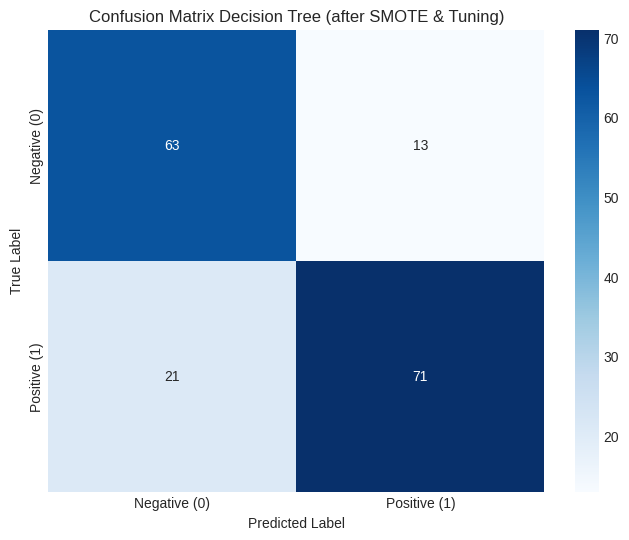

In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# Hitung Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Visualisasikan Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Decision Tree (after SMOTE & Tuning)')
plt.show()

## **6. Visualisasi Pohon Keputusan**

Model terbaik (best_dt_model) ditemukan. Memulai visualisasi pohon keputusan...

Visualisasi Pohon Keputusan (Dibatasi hingga Kedalaman 3):


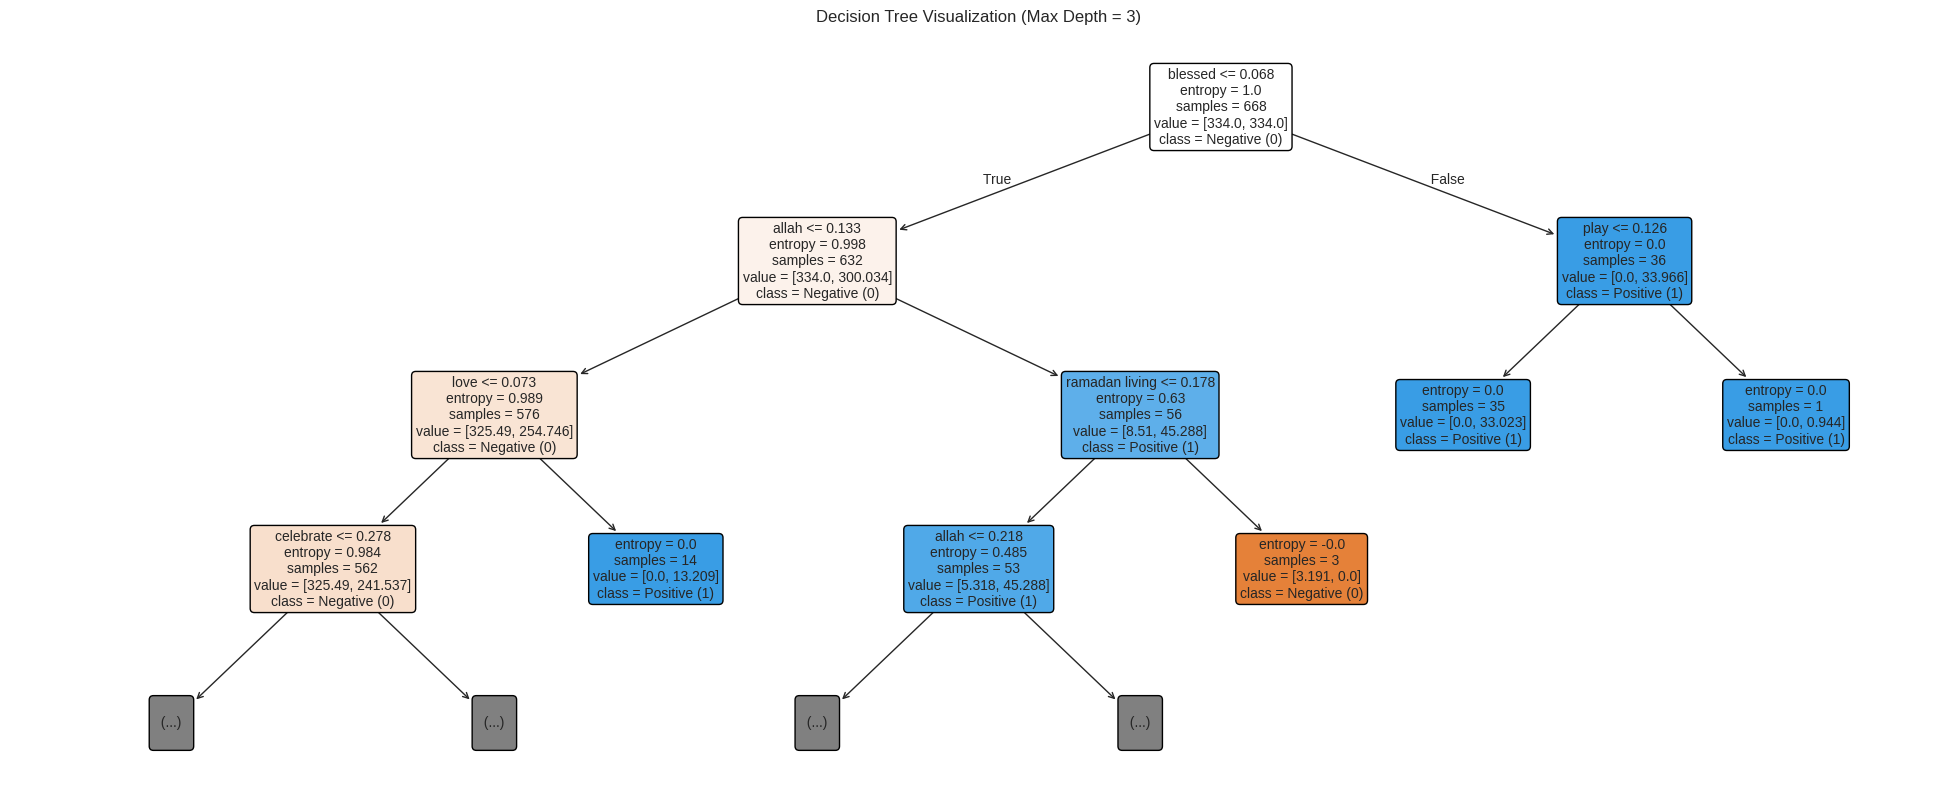


Catatan: Visualisasi ini hanya menampilkan 3 level teratas dari pohon keputusan lengkap.
Pohon keputusan yang sebenarnya mungkin jauh lebih dalam.

Visualisasi pohon keputusan selesai.


In [ ]:
# Import library yang diperlukan
# from sklearn.tree import plot_tree # Menggunakan plot_tree untuk visualisasi yang lebih sederhana
# import matplotlib.pyplot as plt # Untuk menampilkan plot
# import os # Untuk menyimpan file dot

# Pastikan model terbaik (best_dt_model) sudah ada dari tahap tuning
if 'best_dt_model' in locals():
    print("Model terbaik (best_dt_model) ditemukan. Memulai visualisasi pohon keputusan...")

    # Mengatur ukuran plot dan membatasi kedalaman visualisasi
    plt.figure(figsize=(25, 10)) # Mengatur ukuran plot
    max_viz_depth = 3 # Batasi visualisasi hingga kedalaman 3 level

    print(f"\nVisualisasi Pohon Keputusan (Dibatasi hingga Kedalaman {max_viz_depth}):")

    # Visualisasi pohon keputusan menggunakan plot_tree
    plot_tree(
        best_dt_model,
        max_depth=max_viz_depth, # Hanya tampilkan hingga kedalaman ini
        feature_names=tfidf.get_feature_names_out() if hasattr(tfidf, 'get_feature_names_out') else None, # Gunakan nama fitur dari TF-IDF
        class_names=['Negative (0)', 'Positive (1)'], # Nama kelas target
        filled=True,    # Isi node dengan warna kelas mayoritas
        rounded=True,   # Sudut node membulat
        fontsize=10 # Mengatur ukuran font
    )

    plt.title(f'Decision Tree Visualization (Max Depth = {max_viz_depth})') # Menambahkan judul
    plt.show() # Menampilkan plot

    print(f"\nCatatan: Visualisasi ini hanya menampilkan {max_viz_depth} level teratas dari pohon keputusan lengkap.")
    print("Pohon keputusan yang sebenarnya mungkin jauh lebih dalam.")


else:
    print("Model terbaik (best_dt_model) tidak ditemukan. Mohon jalankan tahap 'Pemodelan Decision Tree' terlebih dahulu.")

print("\nVisualisasi pohon keputusan selesai.")